Reference to conversation: https://chatgpt.com/share/6773bd1b-1830-800c-babb-09fcfa530e65

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

## Generating the Synthetic Time Series Data

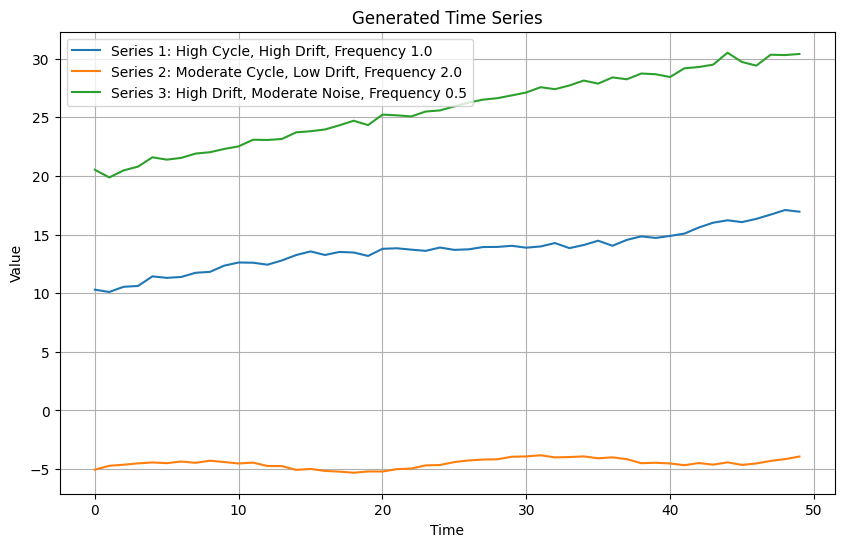

In [2]:
def generate_time_series(length, drift=0.0, cycle_amplitude=0.0, noise_std=0.1, trend_slope=0.0, frequency=1.0, bias=0.0):
    time = np.arange(length)
    base_series = np.full(length, bias)
    trend = trend_slope * time
    cycle = cycle_amplitude * np.sin(2 * np.pi * frequency * time / length)
    noise = np.random.normal(0, noise_std, length)
    drift_array = drift * time
    return base_series + trend + cycle + noise + drift_array

def visualize_time_series(length=100, series_list=None):
    plt.figure(figsize=(10, 6))

    if series_list is not None:
        for i, series in enumerate(series_list):
            plt.plot(series, label=f'Series {i+1}')
    else:
        series1 = generate_time_series(length, drift=0.1, cycle_amplitude=1.0, noise_std=0.2, trend_slope=0.05, frequency=1.0, bias=10.0)
        series2 = generate_time_series(length, drift=0.0, cycle_amplitude=0.5, noise_std=0.1, trend_slope=0.02, frequency=2.0, bias=-5.0)
        series3 = generate_time_series(length, drift=0.2, cycle_amplitude=0.8, noise_std=0.3, trend_slope=0.01, frequency=0.5, bias=20.0)

        plt.plot(series1, label='Series 1: High Cycle, High Drift, Frequency 1.0')
        plt.plot(series2, label='Series 2: Moderate Cycle, Low Drift, Frequency 2.0')
        plt.plot(series3, label='Series 3: High Drift, Moderate Noise, Frequency 0.5')

    plt.title('Generated Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_time_series(50)

## Datasets, Quantization and Data Loader

In [3]:
# Step 2: Custom DataLoader for autoregressive samples
class MultiTimeSeriesDataset:
    BOS_TOKEN = -101  # Beginning of Sequence
    EOS_TOKEN = -102  # End of Sequence
    PAD_TOKEN = -103  # Padding Token

    def __init__(self, series_list, max_training_length, num_classes):
        self.series_list = series_list
        self.max_training_length = max_training_length
        self.num_classes = num_classes
        self.range_min = -100
        self.range_max = 100
        self.range_precision = (self.range_max - self.range_min) / num_classes

    def normalize_vector(self, vector):
        min_val = np.min(vector)
        max_val = np.max(vector)
        return (vector - min_val) / (max_val - min_val), min_val, max_val

    def quantize_vector(self, normalized_vector):
        quantized_levels = np.arange(self.range_min, self.range_max + self.range_precision, self.range_precision)
        quantized_vector = self.range_min + np.round((normalized_vector * (self.range_max - self.range_min)) / self.range_precision) * self.range_precision
        return np.clip(quantized_vector, self.range_min, self.range_max)

    def __len__(self):
        return len(self.series_list)

    def __getitem__(self, index):
        # Get the specified series
        series = self.series_list[index]

        # Randomly pick a starting point
        start_idx = random.randint(0, len(series)- 1)
        end_idx = min(start_idx + self.max_training_length, len(series))

        # Extract a segment
        segment = series[start_idx:end_idx]

        # Normalize the segment
        normalized_segment, original_min, original_max = self.normalize_vector(segment)

        # Quantize the normalized segment
        quantized_segment = self.quantize_vector(normalized_segment)

        # Add BOS and EOS tokens as needed
        sequence = quantized_segment.tolist()
        if start_idx == 0:
            sequence.insert(0, self.BOS_TOKEN)
        if end_idx == len(series):
            sequence.append(self.EOS_TOKEN)

        return torch.tensor(sequence, dtype=torch.float32)

In [4]:
class AutoregressiveLoader:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.cache = []  # Cache now holds tuples of (x, y)
        self.current_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        batched_x, batched_y = [], []

        while len(batched_x) < self.batch_size:
            if self.cache:
                cached_x, cached_y = self.cache.pop(0)
                batched_x.append(cached_x)
                batched_y.append(cached_y)
            else:
                if self.current_index >= len(self.dataset):
                    if batched_x:
                        break
                    self.current_index = 0
                    raise StopIteration

                sample = self.dataset[self.current_index].tolist()
                self.current_index += 1

                for i in range(1, len(sample)):
                    if i == 1 and sample[0] == MultiTimeSeriesDataset.BOS_TOKEN:  # Skip if the first token is BOS
                        continue
                    x = sample[:i]
                    y = sample[i:i+1]
                    x_tensor = torch.tensor(x, dtype=torch.float32)
                    y_tensor = torch.tensor(y, dtype=torch.float32)

                    if len(batched_x) < self.batch_size:
                        batched_x.append(x_tensor)
                        batched_y.append(y_tensor)
                    else:
                        self.cache.append((x_tensor, y_tensor))

        if batched_x:
            return torch.nn.utils.rnn.pad_sequence(batched_x, batch_first=True, padding_value=MultiTimeSeriesDataset.PAD_TOKEN), \
                   torch.nn.utils.rnn.pad_sequence(batched_y, batch_first=True, padding_value=MultiTimeSeriesDataset.PAD_TOKEN)
        raise StopIteration

## Model Architecture

In [5]:
# Step 3: Multi-block decoder only transformer
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, num_layers, model_dim, num_heads, hidden_dim):
        super(DecoderOnlyTransformer, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=hidden_dim)
            for _ in range(num_layers)
        ])
        self.embedding = nn.Linear(1, model_dim)
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.embedding(x.unsqueeze(-1))
        for layer in self.layers:
            x = layer(x, x)  # Decoder only context
        return self.fc_out(x).squeeze(-1)


## Training (Single and Multi-GPU)

In [6]:
# Step 4: Training loop
def train_model(model, train_loader, epochs, device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)  # Predict next classes
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader)}")

In [7]:
# Step 5: Multi-GPU support using DataParallel
def train_model_multi_gpu(model, train_loader, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = nn.DataParallel(model)
    train_model(model, train_loader, epochs, device)

## Driver Code

In [8]:
# Step 6: Generate data and evaluate
# Generate multiple time series
num_series = 10
series_length = 50
max_training_length = 1024
num_classes = 200

series_list = [generate_time_series(series_length, drift=random.uniform(0, 0.2),
                                    cycle_amplitude=random.uniform(0.5, 1.5),
                                    noise_std=random.uniform(0.1, 0.3),
                                    trend_slope=random.uniform(0, 0.05),
                                    frequency=random.uniform(0.5, 2.0),
                                    bias=random.uniform(-10000, 10000)) for _ in range(num_series)]

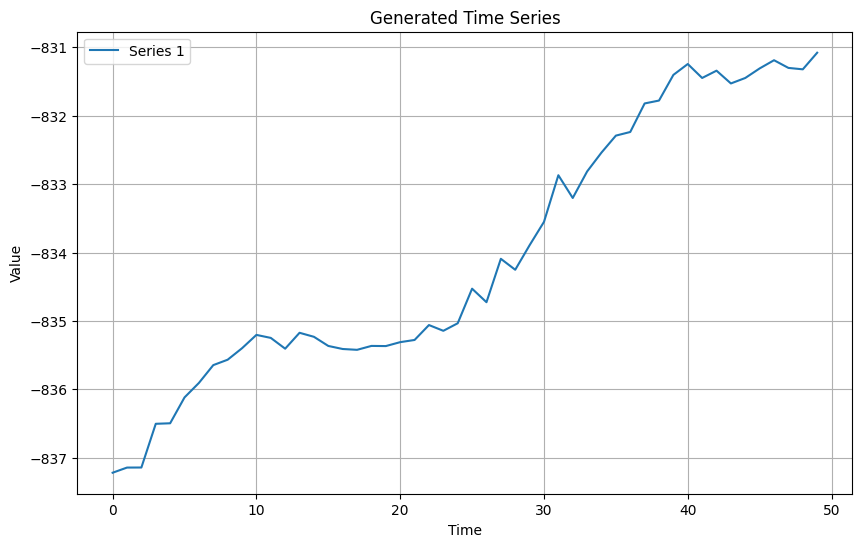

In [9]:
visualize_time_series(series_list=series_list[1:2])

In [10]:
dataset = MultiTimeSeriesDataset(series_list, max_training_length, num_classes)

print('Unique Elements in series:', np.unique(dataset[9].numpy()).size)

Unique Elements in series: 15


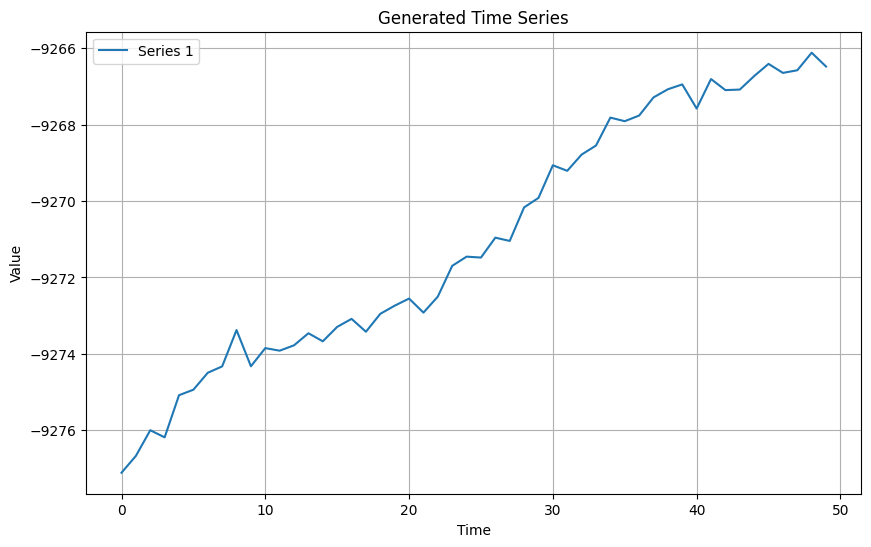

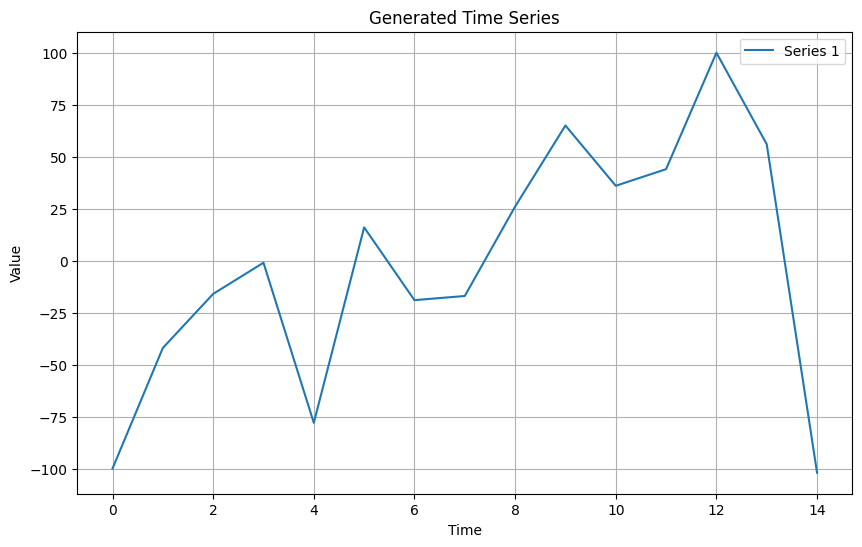

In [11]:
seq_q = dataset[0]
seq_og = series_list[0]
visualize_time_series(series_list=[seq_og])
visualize_time_series(series_list=[seq_q])

In [13]:
train_loader = AutoregressiveLoader(dataset, batch_size=16)
print(f'Initial Cache:{len(train_loader.cache)}, Cache Dim:{train_loader.cache[0][0].shape if train_loader.cache else None}')
for i, (x,y) in enumerate(train_loader):
    print('Iteration #',i)
    print(f'Cache:{len(train_loader.cache)}, Cache Dim:{train_loader.cache[0][0].shape if train_loader.cache else None}')
    print(f'X:{x.shape}, Y:{y.shape}') 

Initial Cache:0, Cache Dim:None
Iteration # 0
Cache:28, Cache Dim:torch.Size([17])
X:torch.Size([16, 16]), Y:torch.Size([16, 1])
Iteration # 1
Cache:12, Cache Dim:torch.Size([33])
X:torch.Size([16, 32]), Y:torch.Size([16, 1])
Iteration # 2
Cache:31, Cache Dim:torch.Size([5])
X:torch.Size([16, 44]), Y:torch.Size([16, 1])
Iteration # 3
Cache:15, Cache Dim:torch.Size([21])
X:torch.Size([16, 20]), Y:torch.Size([16, 1])
Iteration # 4
Cache:16, Cache Dim:torch.Size([2])
X:torch.Size([16, 35]), Y:torch.Size([16, 1])
Iteration # 5
Cache:0, Cache Dim:None
X:torch.Size([16, 17]), Y:torch.Size([16, 1])
Iteration # 6
Cache:12, Cache Dim:torch.Size([17])
X:torch.Size([16, 16]), Y:torch.Size([16, 1])
Iteration # 7
Cache:17, Cache Dim:torch.Size([5])
X:torch.Size([16, 28]), Y:torch.Size([16, 1])
Iteration # 8
Cache:1, Cache Dim:torch.Size([21])
X:torch.Size([16, 20]), Y:torch.Size([16, 1])
Iteration # 9
Cache:6, Cache Dim:torch.Size([16])
X:torch.Size([16, 21]), Y:torch.Size([16, 1])
Iteration # 10
C

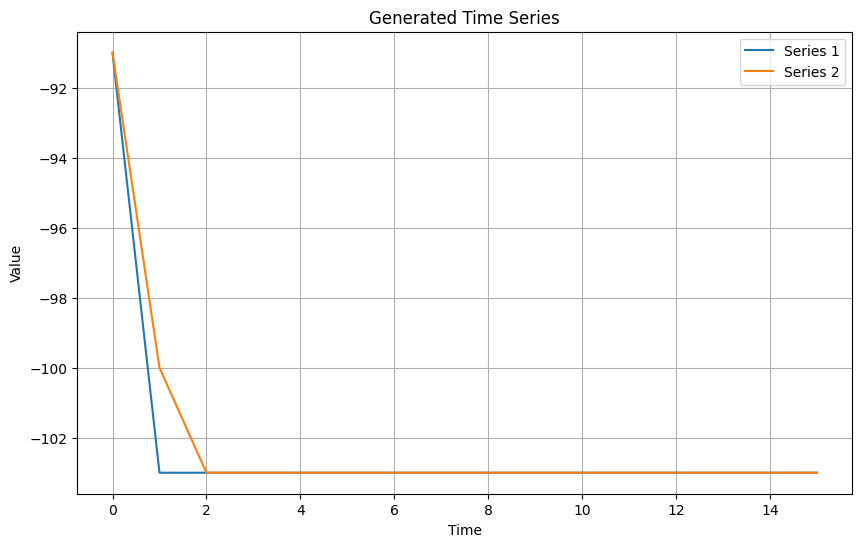

In [14]:
train_loader = AutoregressiveLoader(dataset, batch_size=16)
x, y = next(train_loader)
visualize_time_series(series_list=x[:2])

In [15]:
x, y = next(train_loader)

In [16]:
x

tensor([[ -91., -100.,  -72.,  -57.,  -10.,  -16.,   -6.,   24.,   38.,   46.,
            5.,   55.,   37.,   38.,   60.,   81.,   66., -103., -103., -103.],
        [ -91., -100.,  -72.,  -57.,  -10.,  -16.,   -6.,   24.,   38.,   46.,
            5.,   55.,   37.,   38.,   60.,   81.,   66.,   70., -103., -103.],
        [ -91., -100.,  -72.,  -57.,  -10.,  -16.,   -6.,   24.,   38.,   46.,
            5.,   55.,   37.,   38.,   60.,   81.,   66.,   70.,  100., -103.],
        [ -91., -100.,  -72.,  -57.,  -10.,  -16.,   -6.,   24.,   38.,   46.,
            5.,   55.,   37.,   38.,   60.,   81.,   66.,   70.,  100.,   77.],
        [-100., -103., -103., -103., -103., -103., -103., -103., -103., -103.,
         -103., -103., -103., -103., -103., -103., -103., -103., -103., -103.],
        [-100.,  -89., -103., -103., -103., -103., -103., -103., -103., -103.,
         -103., -103., -103., -103., -103., -103., -103., -103., -103., -103.],
        [-100.,  -89.,   13., -103., -103., -1

In [21]:
torch.triu(torch.ones((10, 10)))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [24]:
mask = torch.ones(1, 10,10)
mask = mask.masked_fill(mask == 0, float('-inf'))

In [25]:
mask

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [ ]:
# Define and train the model
model = DecoderOnlyTransformer(num_layers=4, model_dim=64, num_heads=4, hidden_dim=128)

In [27]:
x.shape

torch.Size([16, 20])

In [29]:
x.clone().shape

torch.Size([16, 20])

In [32]:
padding_mask = x.clone()
padding_mask = padding_mask.masked_fill(padding_mask != -103, 0).bool()
#padding_mask = padding_mask.masked_fill(padding_mask == -103, True)


In [34]:
padding_mask.int()

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0,

In [43]:
attn_mask = torch.triu(torch.ones((10,10))).bool()
attn_mask = ~attn_mask
attn_mask

tensor([[False, False, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False]])